# Lab 3

Group 2 Members: Josh Mitchell, Adam Alidra, Ryan Herrin

This lab exercise is the third of three labs, completing our study of identifying obfuscated data present in PowerShell script. Through this process we've leveraged the complete data science lifecycle including various machine learning models to identify malicious code programmatically, enabling current and future data scientists to reuse this approach in an enterprise setting. 

The goal has and continues to be, proactively discovering obfuscated data in enterprise environments, mitigating the risk of downtime, data leaks, and irrevocable damage to organization's reputations.

In this particular lab, we use clustering on an unlabeled dataset to provide insights that will empower cybersecurity analysts to prevent breaches.

In [2]:
#import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn import cluster
from sklearn import metrics
import scipy
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from ps_obf import PS_OBF # Custom class 
%matplotlib inline
plt.style.use('ggplot')

Below is an object created from a custom class made at the beginning of this project. The class takes in our csv data and has a pipeline of steps that transforms the data and creates a PCA dataset from it. This PCA data can be used by assigning the PS_OBF.pca_df variable.

We landed on the PCA dataset over the other datasets we originally compared against as it isolated the features that had the most signficance relative to identifying obfuscation while producing the highest accuracy and lowest False Negatives, over other models we ran including KNN, Naive Bayes, and Logistic Regression. Recall, it's important in this particular study we don't let false negatives slip through the cracks given the serious risk unidentified obfuscated data presents.

Hence, the PCA dataset includes 10405 observations and 2 principal components which we will use to conduct clustering in Lab 3. Note, since Lab 3 compounds the work we previously conducted in Lab 1 and 2, data has been tidied, transformed, and no null values were originally present, therefore missing data is a nonfactor going forward.

In [3]:
ps_obf_data = PS_OBF('../dataset/all_with_keyword_sum.csv', transform=True)

# Assign PCA data 
pca_data = ps_obf_data.pca_df

Reminder of what the PCA data looks like on a scatter plot

Text(0.5, 1.0, 'PCA Data')

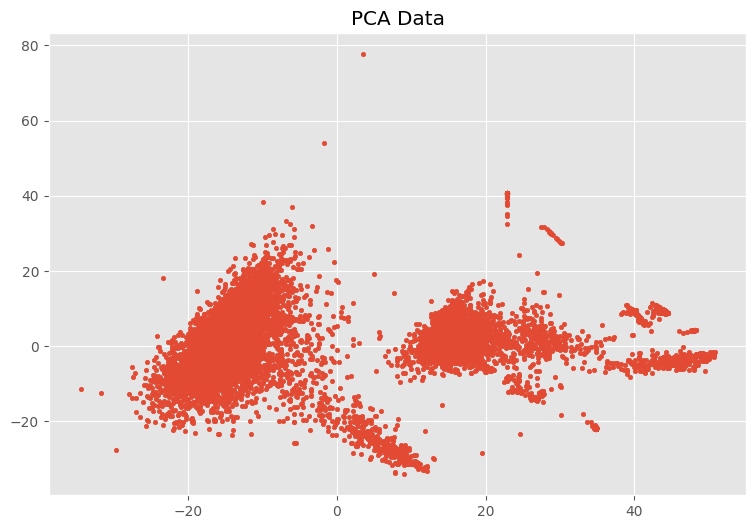

In [67]:
# Plot what the PCA data looks like on a scatter plot
plt.figure(figsize=(9, 6))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10)
plt.title("PCA Data")

## DBSCAN

In this next section, we execute an unsupervised clustering machine learning algorithm, using DBSCAN, a density-based clustering of applications with noise. DBSCAN does not require pre-labeled targets to cluster data points, and is better suited than K-NNN, for example, to handle globular clusters and/or clusters of multiple sizes, with the added benefit of being robust to outliers.

DBSCAN typically requires two parameters, epsilon and minPoints. Epsilon is the max radius of the circle to be created around a data point while checking the distance between it and another data point to ultimately determine if the two points are similar enough to belong together. minPoints represents the minimum number of data points required within the radius of circle for the data point to be classified as a 'Core' point or broadly speaking, a cluster.

optimal epsilon: 1.118403807740172


<Figure size 500x500 with 0 Axes>

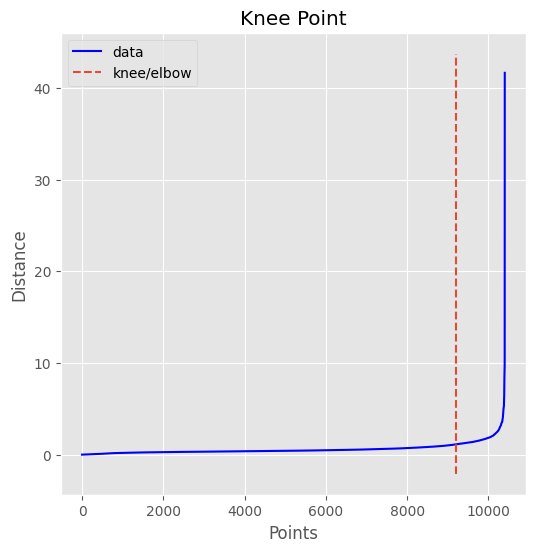

In [70]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(pca_data)

distances, indices = neighbors.kneighbors(pca_data)
distances = np.sort(distances[:,10], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print('optimal epsilon:', distances[knee.knee])

Above, we obtain an optimal epsilon value of 1.118, which is depicted through the knee point plot. To corroborate our programmatic findings, you'll see the plot displays the optimal value for epsilon occurring at the point of maximum curvature (right above '1' on the y-axis).

A 1.118 epsilon value is generally a good indication the 

In [79]:
#eps = 1.118403807740172
eps = distances[knee.knee]
v_measures = {}
df = ps_obf_data.data.copy()
for min_samples in range(1,100):
    # build and fit the model
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(pca_data)

    # get the number of clusters
    labels = dbscan.labels_
    num_clusters = len(set(labels))-(1 if -1 in labels else 0)
    #print('estimated number of clusters:', num_clusters)

    # identify noise
    n_noise = list(dbscan.labels_).count(-1)
    #print('estimated number of noise points:',n_noise)

    # calculate normalized mutual information score
    #print('v_measure =', v_measure_score(df['is_obf'], labels))
    v_measures[v_measure_score(df['is_obf'], labels)] = {'min_samples': min_samples, 'n_noise': n_noise, 'num_clusters': num_clusters}
mk = max(v_measures.keys())
print('best v-measure:', mk, v_measures[mk])

best v-measure: 0.47870187078219967 {'min_samples': 3, 'n_noise': 173, 'num_clusters': 36}


0.016710297902957204

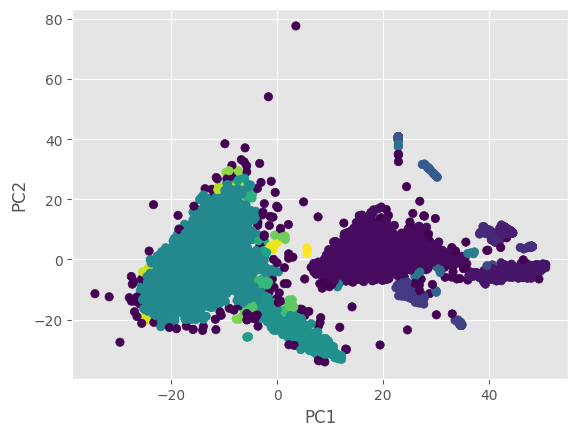

In [78]:
dbscan = cluster.DBSCAN(eps=eps, min_samples = v_measures[mk]['min_samples'])
dbscan.fit(pca_data)
plt.scatter(pca_data[:,0], pca_data[:,1], c=dbscan.labels_)
plt.xlabel("PC1")
plt.ylabel("PC2")
# silhouette score close to zero so we have some overlapping clusters and not well defined cluster boundaries
metrics.silhouette_score(pca_data, dbscan.labels_)

# UMAP

In [ ]:
#import sys
#!{sys.executable} -m pip install umap-learn
import umap

In [143]:
data = ps_obf_data.split(ps_obf_data.data)
train_df = data['train'].copy()
train_df.drop(['is_obf'], axis=1, inplace=True)
trans = umap.UMAP(n_neighbors=50, n_components=2,random_state=42).fit(train_df)

Text(0.5, 1.0, 'Embedding of the training set by UMAP')

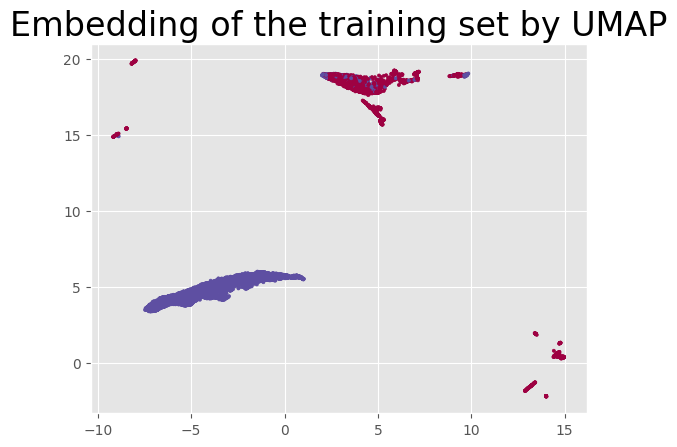

In [142]:

plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=data['train']['is_obf'], cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24)

In [120]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
svc = SVC().fit(trans.embedding_, data['train']['is_obf'])
knn = KNeighborsClassifier().fit(trans.embedding_, data['train']['is_obf'])

In [117]:
X_test = data['test'].copy()
X_test.drop(['is_obf'], inplace=True, axis=1)
y_test = data['test_labels']
#test_embedding = trans.transform(X_test)

In [118]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9509851033157136, 0.9567515617491591)

In [130]:
pca_s = ps_obf_data.split(pca_data)
pca_s.keys()
pca_s['train'].drop(['is_obf'], axis=1, inplace=True)
pca_s['test'].drop(['is_obf'], axis=1, inplace=True)
svc = SVC().fit(pca_s['train'], pca_s['train_labels'])
knn = KNeighborsClassifier().fit(pca_s['train'], data['train']['is_obf'])
svc.score(pca_s['test'], pca_s['test_labels']), knn.score(pca_s['test'], pca_s['test_labels'])

(0.9529072561268621, 0.9533877943296492)